# 

In [14]:
import numpy as np
import pandas as pd
import os

In [15]:
test_dir = '/kaggle/input/raf-db-dataset/DATASET/test'
train_dir = '/kaggle/input/raf-db-dataset/DATASET/train'

In [16]:
!ls /kaggle/input/raf-db-dataset/DATASET/test/1/test_0002_aligned.jpg

/kaggle/input/raf-db-dataset/DATASET/test/1/test_0002_aligned.jpg


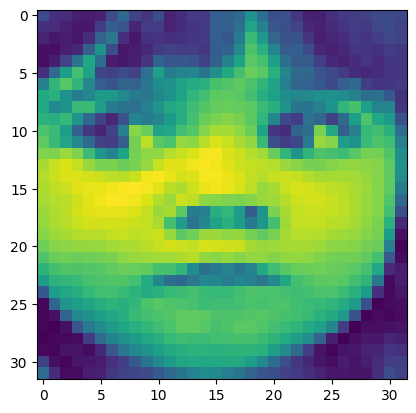

In [17]:
from PIL import Image,ImageOps

import matplotlib.pyplot as plt
import numpy as np

size = 32
    
required_size=(size, size)
image = ImageOps.grayscale(Image.open('/kaggle/input/raf-db-dataset/DATASET/test/1/test_0002_aligned.jpg')).resize(required_size)
img_arr = np.array(image)#.reshape(size*size)

imgplot = plt.imshow(img_arr)

In [18]:
def dataset_by_path(path):
    size = 32
    X = []
    y = []
    required_size=(size, size)
    i=0

    for class_name in os.listdir(path):
        path_to =path+'/'+class_name
        for img_path in os.listdir(path_to):
            y.append(int(class_name))
            
            image = ImageOps.grayscale(Image.open(path_to+'/'+img_path)).resize(required_size)
            img_arr = np.array(image).reshape(size*size)
            X.append(img_arr)
    return np.array(X),np.array(y)



In [19]:
test_f ,test_label =dataset_by_path(test_dir)
train_f ,train_label =dataset_by_path(train_dir)


In [20]:
print(train_f.shape)
print(train_label.shape)

(12271, 1024)
(12271,)


In [21]:
from pandas import DataFrame
import warnings
warnings.filterwarnings("ignore")

In [22]:
name_col= [str(i) for i in range(32*32)]
X_train = DataFrame()
X_train[name_col] = train_f
Y_train = DataFrame()
Y_train['label'] = train_label
X_test = DataFrame()
X_test[name_col] = test_f
Y_test = DataFrame()
Y_test['label'] = test_label

In [23]:
Y_train.value_counts()

label
4        4772
7        2524
5        1982
1        1290
3         717
6         705
2         281
Name: count, dtype: int64

In [24]:
import optuna

import catboost as cb
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

def objective(trial):
    x, xt, y, yt = train_f,test_f,train_label,test_label
    param = {
        "objective": trial.suggest_categorical("objective", ["MultiClass", "MultiClassOneVsAll"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli"]
        ),
        "used_ram_limit": "25gb",
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.02, 0.05, 0.08, 0.1]),
        'n_estimators': trial.suggest_int('n_estimators', 4, 200),
        'max_bin': trial.suggest_int('max_bin', 100, 400),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log=True),
        'random_seed': 42,
        'task_type': 'CPU',
        'eval_metric': 'Accuracy',
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    pca_param ={
        "n_components": trial.suggest_float("n_components", 0.5, 0.9999),
        'power_iteration_normalizer': trial.suggest_categorical('power_iteration_normalizer',
            ['auto', 'QR', 'LU', 'none']
        ),
        'svd_solver':'full',

    }
    
    pca = PCA(**pca_param).fit(x,y)
    x = pca.transform(x)
    xt = pca.transform(xt)
    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(x, y, eval_set=[(xt, yt)], verbose=0, early_stopping_rounds=10)
    preds = gbm.predict(xt)
    pred_labels = np.rint(preds)

    ac = gbm.get_best_score()['validation']['Accuracy']
    print(ac)
    return ac

In [25]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, timeout=600, n_jobs=-1)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-10-21 20:42:59,996] A new study created in memory with name: no-name-4ccadd1f-58a4-4c25-8013-91d4dc4063b8
[I 2023-10-21 20:43:11,659] Trial 1 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.07967660530513697, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'max_depth': 5, 'learning_rate': 0.005, 'n_estimators': 136, 'max_bin': 279, 'min_data_in_leaf': 168, 'l2_leaf_reg': 0.21081585095806918, 'subsample': 0.5108901359036917, 'n_components': 0.625838102444808, 'power_iteration_normalizer': 'none'}. Best is trial 1 with value: 0.386245110821382.


0.386245110821382


[I 2023-10-21 20:43:21,720] Trial 2 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09967826704729729, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 8, 'learning_rate': 0.05, 'n_estimators': 139, 'max_bin': 100, 'min_data_in_leaf': 132, 'l2_leaf_reg': 0.002060990130375866, 'bagging_temperature': 4.663480577236162, 'n_components': 0.6151452607395511, 'power_iteration_normalizer': 'QR'}. Best is trial 1 with value: 0.386245110821382.


0.386245110821382


[I 2023-10-21 20:43:35,038] Trial 5 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.08554411634505665, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 42, 'max_bin': 100, 'min_data_in_leaf': 176, 'l2_leaf_reg': 0.008667845729912575, 'subsample': 0.2125296630181349, 'n_components': 0.6976893506440712, 'power_iteration_normalizer': 'QR'}. Best is trial 1 with value: 0.386245110821382.


0.386245110821382


[I 2023-10-21 20:43:46,022] Trial 4 finished with value: 0.40547588005215124 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.06234536266201865, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'max_depth': 3, 'learning_rate': 0.02, 'n_estimators': 112, 'max_bin': 278, 'min_data_in_leaf': 183, 'l2_leaf_reg': 0.2823547666309024, 'subsample': 0.7535466702469678, 'n_components': 0.9442273220760672, 'power_iteration_normalizer': 'none'}. Best is trial 4 with value: 0.40547588005215124.


0.40547588005215124


[I 2023-10-21 20:43:55,748] Trial 0 finished with value: 0.4302477183833116 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09387871593706437, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'max_depth': 12, 'learning_rate': 0.05, 'n_estimators': 42, 'max_bin': 285, 'min_data_in_leaf': 218, 'l2_leaf_reg': 0.9743408276612554, 'subsample': 0.9627620526102836, 'n_components': 0.8230280108584973, 'power_iteration_normalizer': 'LU'}. Best is trial 0 with value: 0.4302477183833116.


0.4302477183833116


[I 2023-10-21 20:43:59,239] Trial 7 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.05705868993210546, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'max_depth': 4, 'learning_rate': 0.08, 'n_estimators': 144, 'max_bin': 118, 'min_data_in_leaf': 53, 'l2_leaf_reg': 0.005658563108719952, 'subsample': 0.6287423318263143, 'n_components': 0.828136656478484, 'power_iteration_normalizer': 'none'}. Best is trial 0 with value: 0.4302477183833116.


0.386245110821382


[I 2023-10-21 20:43:59,660] Trial 8 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09026806195984005, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 153, 'max_bin': 367, 'min_data_in_leaf': 217, 'l2_leaf_reg': 0.3721429462549987, 'subsample': 0.1356887335855518, 'n_components': 0.7593972358935197, 'power_iteration_normalizer': 'LU'}. Best is trial 0 with value: 0.4302477183833116.


0.386245110821382


[I 2023-10-21 20:44:08,427] Trial 3 finished with value: 0.4194915254237288 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.030485544720576907, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 12, 'learning_rate': 0.05, 'n_estimators': 67, 'max_bin': 151, 'min_data_in_leaf': 195, 'l2_leaf_reg': 0.0047480270576680025, 'bagging_temperature': 3.8938776670239283, 'n_components': 0.9512023884503186, 'power_iteration_normalizer': 'QR'}. Best is trial 0 with value: 0.4302477183833116.


0.4194915254237288


[I 2023-10-21 20:44:16,691] Trial 6 finished with value: 0.5586701434159062 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.043367668845719166, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 188, 'max_bin': 130, 'min_data_in_leaf': 71, 'l2_leaf_reg': 0.04990952068756947, 'subsample': 0.7354527356201, 'n_components': 0.8816130108928346, 'power_iteration_normalizer': 'LU'}. Best is trial 6 with value: 0.5586701434159062.


0.5586701434159062


[I 2023-10-21 20:44:20,120] Trial 10 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.0622762972445136, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 10, 'learning_rate': 0.005, 'n_estimators': 166, 'max_bin': 272, 'min_data_in_leaf': 267, 'l2_leaf_reg': 0.006832221876446835, 'bagging_temperature': 7.538135264254415, 'n_components': 0.5812480786594608, 'power_iteration_normalizer': 'QR'}. Best is trial 6 with value: 0.5586701434159062.


0.386245110821382


[I 2023-10-21 20:44:27,768] Trial 11 finished with value: 0.4090612777053455 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.09301668901137337, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 10, 'learning_rate': 0.02, 'n_estimators': 142, 'max_bin': 351, 'min_data_in_leaf': 161, 'l2_leaf_reg': 0.08450687165048165, 'bagging_temperature': 0.1413097105845551, 'n_components': 0.9364474663769551, 'power_iteration_normalizer': 'LU'}. Best is trial 6 with value: 0.5586701434159062.
[I 2023-10-21 20:44:27,778] Trial 9 finished with value: 0.5528031290743155 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.08050808715551239, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 196, 'max_bin': 160, 'min_data_in_leaf': 257, 'l2_leaf_reg': 0.03707022868357889, 'bagging_temperature': 1.6551671770129595, 'n_components': 0.8605600710028026, 'power_iteration_normalizer': 

0.4090612777053455
0.5528031290743155


[I 2023-10-21 20:44:33,516] Trial 13 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.010635597914443254, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 194, 'max_bin': 185, 'min_data_in_leaf': 15, 'l2_leaf_reg': 0.00016245477394771576, 'bagging_temperature': 0.2232306254212224, 'n_components': 0.5050189766981186, 'power_iteration_normalizer': 'auto'}. Best is trial 6 with value: 0.5586701434159062.


0.386245110821382


[I 2023-10-21 20:44:37,271] Trial 14 finished with value: 0.3921121251629726 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.034110473136751696, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 194, 'max_bin': 175, 'min_data_in_leaf': 66, 'l2_leaf_reg': 0.03438502600010803, 'bagging_temperature': 0.6744797701480518, 'n_components': 0.853075566912852, 'power_iteration_normalizer': 'auto'}. Best is trial 6 with value: 0.5586701434159062.


0.3921121251629726


[I 2023-10-21 20:44:37,660] Trial 15 finished with value: 0.41883963494132986 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.04073468854735893, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 199, 'max_bin': 183, 'min_data_in_leaf': 8, 'l2_leaf_reg': 0.03500478258742491, 'bagging_temperature': 0.5312679454671212, 'n_components': 0.8556447202971755, 'power_iteration_normalizer': 'auto'}. Best is trial 6 with value: 0.5586701434159062.


0.41883963494132986


[I 2023-10-21 20:44:44,050] Trial 12 finished with value: 0.3891786179921773 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.014511534624803974, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 7, 'learning_rate': 0.08, 'n_estimators': 49, 'max_bin': 133, 'min_data_in_leaf': 183, 'l2_leaf_reg': 0.0052295790584233936, 'bagging_temperature': 5.44987816966692, 'n_components': 0.9967685078857293, 'power_iteration_normalizer': 'LU'}. Best is trial 6 with value: 0.5586701434159062.


0.3891786179921773
0.39276401564537156


[I 2023-10-21 20:44:44,053] Trial 16 finished with value: 0.39276401564537156 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.04293001583984908, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 197, 'max_bin': 206, 'min_data_in_leaf': 97, 'l2_leaf_reg': 0.04263709910885883, 'bagging_temperature': 9.982190440132147, 'n_components': 0.8638811674288602, 'power_iteration_normalizer': 'auto'}. Best is trial 6 with value: 0.5586701434159062.
[I 2023-10-21 20:44:52,886] Trial 19 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.06960992442398978, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 5, 'max_bin': 222, 'min_data_in_leaf': 298, 'l2_leaf_reg': 0.10029425920176402, 'subsample': 0.9063869565278455, 'n_components': 0.7638567486307891, 'power_iteration_normalizer': 'none'}. B

0.386245110821382
0.3963494132985658


[I 2023-10-21 20:45:00,466] Trial 18 finished with value: 0.5469361147327249 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.07558769017748151, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 94, 'max_bin': 212, 'min_data_in_leaf': 300, 'l2_leaf_reg': 0.037589075965538295, 'subsample': 0.9642577302776433, 'n_components': 0.9113746929734864, 'power_iteration_normalizer': 'LU'}. Best is trial 6 with value: 0.5586701434159062.
[I 2023-10-21 20:45:00,467] Trial 17 finished with value: 0.3859191655801825 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.07486825910632114, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 5, 'max_bin': 217, 'min_data_in_leaf': 108, 'l2_leaf_reg': 0.03899406399634348, 'subsample': 0.8773313349423857, 'n_components': 0.9917561766792449, 'power_iteration_normalizer': 'none'}. Best is tr

0.38591916558018250.5469361147327249



[I 2023-10-21 20:45:08,887] Trial 22 finished with value: 0.5488917861799217 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.07068316649396823, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 110, 'max_bin': 153, 'min_data_in_leaf': 120, 'l2_leaf_reg': 0.02127362365234351, 'subsample': 0.4767428040987502, 'n_components': 0.9012897633243538, 'power_iteration_normalizer': 'LU'}. Best is trial 6 with value: 0.5586701434159062.


0.5488917861799217


[I 2023-10-21 20:45:11,954] Trial 24 finished with value: 0.5254237288135594 and parameters: {'objective': 'MultiClassOneVsAll', 'colsample_bylevel': 0.08386642076974654, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 102, 'max_bin': 142, 'min_data_in_leaf': 253, 'l2_leaf_reg': 0.014093425230231073, 'subsample': 0.769785537821564, 'n_components': 0.906386624911648, 'power_iteration_normalizer': 'LU'}. Best is trial 6 with value: 0.5586701434159062.
[I 2023-10-21 20:45:11,958] Trial 21 finished with value: 0.5508474576271186 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.07455074606751912, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 171, 'max_bin': 151, 'min_data_in_leaf': 101, 'l2_leaf_reg': 0.024649478903834506, 'subsample': 0.4666824316513079, 'n_components': 0.9101785417262945, 'power_iteration_normalizer': 'LU'}. Best is trial 6 with

0.5254237288135594
0.5508474576271186
0.5133637548891786


[I 2023-10-21 20:45:20,868] Trial 26 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.052748363563749075, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'max_depth': 4, 'learning_rate': 0.02, 'n_estimators': 178, 'max_bin': 122, 'min_data_in_leaf': 54, 'l2_leaf_reg': 0.06258218706672364, 'subsample': 0.3956424863924046, 'n_components': 0.8135041463890894, 'power_iteration_normalizer': 'LU'}. Best is trial 6 with value: 0.5586701434159062.
[I 2023-10-21 20:45:20,923] Trial 28 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.05608797493633119, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'max_depth': 4, 'learning_rate': 0.005, 'n_estimators': 176, 'max_bin': 124, 'min_data_in_leaf': 70, 'l2_leaf_reg': 0.12279103538842273, 'subsample': 0.4116473851420077, 'n_components': 0.8023425769259238, 'power_iteration_normalizer': 'LU'}. Best is trial 6 with value: 

0.386245110821382
0.386245110821382
0.386245110821382


[I 2023-10-21 20:45:21,186] Trial 25 finished with value: 0.5221642764015645 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.05094679242152783, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 110, 'max_bin': 154, 'min_data_in_leaf': 71, 'l2_leaf_reg': 0.013242935048505884, 'subsample': 0.47712953577228734, 'n_components': 0.9033735329229042, 'power_iteration_normalizer': 'LU'}. Best is trial 6 with value: 0.5586701434159062.


0.5221642764015645


[I 2023-10-21 20:45:39,239] Trial 29 finished with value: 0.5570404172099087 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.06727877240984478, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 6, 'learning_rate': 0.08, 'n_estimators': 161, 'max_bin': 240, 'min_data_in_leaf': 83, 'l2_leaf_reg': 0.16626414203472137, 'bagging_temperature': 2.522321720741486, 'n_components': 0.8700024669124203, 'power_iteration_normalizer': 'none'}. Best is trial 6 with value: 0.5586701434159062.


0.5570404172099087


[I 2023-10-21 20:45:53,161] Trial 32 finished with value: 0.5472620599739244 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.08977956021803371, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 6, 'learning_rate': 0.08, 'n_estimators': 160, 'max_bin': 248, 'min_data_in_leaf': 139, 'l2_leaf_reg': 0.5086079664639465, 'bagging_temperature': 2.485923868239829, 'n_components': 0.8588557940946886, 'power_iteration_normalizer': 'none'}. Best is trial 6 with value: 0.5586701434159062.
[I 2023-10-21 20:45:53,163] Trial 30 finished with value: 0.5573663624511083 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.069098364054951, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 6, 'learning_rate': 0.08, 'n_estimators': 156, 'max_bin': 172, 'min_data_in_leaf': 32, 'l2_leaf_reg': 0.0144965912605187, 'bagging_temperature': 2.4250458892822144, 'n_components': 0.8734080837397843, 'power_iteration_normalizer': 'none'}. Best i

0.55736636245110830.5472620599739244

0.5443285528031291


[I 2023-10-21 20:46:12,635] Trial 33 finished with value: 0.4980443285528031 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.06390803412491797, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 6, 'learning_rate': 0.08, 'n_estimators': 155, 'max_bin': 245, 'min_data_in_leaf': 33, 'l2_leaf_reg': 0.7972316011190165, 'bagging_temperature': 2.451614979098027, 'n_components': 0.840905588344239, 'power_iteration_normalizer': 'none'}. Best is trial 6 with value: 0.5586701434159062.


0.4980443285528031


[I 2023-10-21 20:46:19,999] Trial 34 finished with value: 0.5172750977835724 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.06689068318739452, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 6, 'learning_rate': 0.08, 'n_estimators': 124, 'max_bin': 255, 'min_data_in_leaf': 28, 'l2_leaf_reg': 0.16741720103207808, 'bagging_temperature': 2.4872991539984834, 'n_components': 0.8324822914695421, 'power_iteration_normalizer': 'none'}. Best is trial 6 with value: 0.5586701434159062.
[I 2023-10-21 20:46:20,004] Trial 35 finished with value: 0.5342242503259452 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.08038128167496204, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 8, 'learning_rate': 0.08, 'n_estimators': 126, 'max_bin': 177, 'min_data_in_leaf': 41, 'l2_leaf_reg': 0.1957470113268473, 'bagging_temperature': 2.3335638766336286, 'n_components': 0.8308282618495539, 'power_iteration_normalizer': 'none'}. Bes

0.5172750977835724
0.5342242503259452
0.5019556714471969


[I 2023-10-21 20:46:29,939] Trial 38 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.07986197092136459, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 8, 'learning_rate': 0.08, 'n_estimators': 186, 'max_bin': 194, 'min_data_in_leaf': 94, 'l2_leaf_reg': 0.06127477662770138, 'bagging_temperature': 3.43288522996001, 'n_components': 0.7208300607814039, 'power_iteration_normalizer': 'none'}. Best is trial 6 with value: 0.5586701434159062.
[I 2023-10-21 20:46:29,993] Trial 40 finished with value: 0.386245110821382 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.060413781187606756, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 8, 'learning_rate': 0.08, 'n_estimators': 180, 'max_bin': 197, 'min_data_in_leaf': 92, 'l2_leaf_reg': 0.06446275330909478, 'bagging_temperature': 1.424573016332413, 'n_components': 0.7275627172615786, 'power_iteration_normalizer': 'none'}. Best i

0.386245110821382
0.386245110821382


[I 2023-10-21 20:46:57,036] Trial 39 finished with value: 0.5765971316818774 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.06142732212225389, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 8, 'learning_rate': 0.08, 'n_estimators': 186, 'max_bin': 103, 'min_data_in_leaf': 87, 'l2_leaf_reg': 0.06919241474827643, 'bagging_temperature': 1.4023023179227174, 'n_components': 0.8808654051825928, 'power_iteration_normalizer': 'none'}. Best is trial 39 with value: 0.5765971316818774.


0.5765971316818774


[I 2023-10-21 20:47:08,394] Trial 42 finished with value: 0.5508474576271186 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09848369754321865, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 148, 'max_bin': 103, 'min_data_in_leaf': 209, 'l2_leaf_reg': 0.21413272771124098, 'bagging_temperature': 1.3695448260004868, 'n_components': 0.8749863350738685, 'power_iteration_normalizer': 'QR'}. Best is trial 39 with value: 0.5765971316818774.
[I 2023-10-21 20:47:08,404] Trial 37 finished with value: 0.5625814863102999 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.07897563392302434, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 8, 'learning_rate': 0.08, 'n_estimators': 129, 'max_bin': 308, 'min_data_in_leaf': 89, 'l2_leaf_reg': 0.17623510764762818, 'bagging_temperature': 1.9723340134360983, 'n_components': 0.8816840822307687, 'power_iteration_normalizer': 'none'}. Best

0.5508474576271186
0.5625814863102999


[I 2023-10-21 20:47:29,410] Trial 41 finished with value: 0.5570404172099087 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.09832684547513075, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 8, 'learning_rate': 0.05, 'n_estimators': 186, 'max_bin': 101, 'min_data_in_leaf': 211, 'l2_leaf_reg': 0.23241051991072334, 'bagging_temperature': 1.1300331283939868, 'n_components': 0.8740929946832282, 'power_iteration_normalizer': 'QR'}. Best is trial 39 with value: 0.5765971316818774.


0.5570404172099087


[I 2023-10-21 20:48:55,047] Trial 43 finished with value: 0.5668187744458931 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.05919271537722606, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 9, 'learning_rate': 0.05, 'n_estimators': 144, 'max_bin': 106, 'min_data_in_leaf': 136, 'l2_leaf_reg': 0.3841663574506976, 'bagging_temperature': 1.1855022960247112, 'n_components': 0.9573317422484435, 'power_iteration_normalizer': 'QR'}. Best is trial 39 with value: 0.5765971316818774.


0.5668187744458931


[I 2023-10-21 20:50:47,202] Trial 47 finished with value: 0.5645371577574967 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.0595206619099557, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 9, 'learning_rate': 0.05, 'n_estimators': 136, 'max_bin': 117, 'min_data_in_leaf': 148, 'l2_leaf_reg': 0.3559797741818917, 'bagging_temperature': 0.9336597601546488, 'n_components': 0.9537967884686934, 'power_iteration_normalizer': 'QR'}. Best is trial 39 with value: 0.5765971316818774.


0.5645371577574967


[I 2023-10-21 20:51:25,505] Trial 46 finished with value: 0.559322033898305 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.061246034501647846, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 9, 'learning_rate': 0.08, 'n_estimators': 86, 'max_bin': 310, 'min_data_in_leaf': 118, 'l2_leaf_reg': 0.3210080897219304, 'bagging_temperature': 1.343064046774907, 'n_components': 0.9585950031369883, 'power_iteration_normalizer': 'none'}. Best is trial 39 with value: 0.5765971316818774.


0.559322033898305


[I 2023-10-21 20:51:37,304] Trial 44 finished with value: 0.5629074315514994 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.057545360670091326, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 9, 'learning_rate': 0.08, 'n_estimators': 165, 'max_bin': 384, 'min_data_in_leaf': 83, 'l2_leaf_reg': 0.47239866142525305, 'bagging_temperature': 3.3359870176503357, 'n_components': 0.9445633468414374, 'power_iteration_normalizer': 'none'}. Best is trial 39 with value: 0.5765971316818774.


0.5629074315514994


[I 2023-10-21 20:51:52,350] Trial 48 finished with value: 0.5198826597131682 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.04917682206659789, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 9, 'learning_rate': 0.05, 'n_estimators': 76, 'max_bin': 114, 'min_data_in_leaf': 148, 'l2_leaf_reg': 0.27682600941176616, 'bagging_temperature': 0.11692850313670755, 'n_components': 0.9575519776566194, 'power_iteration_normalizer': 'QR'}. Best is trial 39 with value: 0.5765971316818774.


0.5198826597131682


[I 2023-10-21 20:52:06,646] Trial 45 finished with value: 0.5788787483702738 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.05862058871915618, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 9, 'learning_rate': 0.08, 'n_estimators': 135, 'max_bin': 337, 'min_data_in_leaf': 121, 'l2_leaf_reg': 0.3217602445309221, 'bagging_temperature': 3.337694181588498, 'n_components': 0.943584711853355, 'power_iteration_normalizer': 'none'}. Best is trial 45 with value: 0.5788787483702738.


0.5788787483702738


[I 2023-10-21 20:52:42,124] Trial 50 finished with value: 0.4132985658409387 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.04896495411871486, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 9, 'learning_rate': 0.05, 'n_estimators': 131, 'max_bin': 370, 'min_data_in_leaf': 150, 'l2_leaf_reg': 0.40841259532588287, 'bagging_temperature': 1.0664850936864334, 'n_components': 0.964355932092252, 'power_iteration_normalizer': 'QR'}. Best is trial 45 with value: 0.5788787483702738.


0.4132985658409387


[I 2023-10-21 20:54:40,474] Trial 51 finished with value: 0.45436766623207303 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.05630425328394884, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 11, 'learning_rate': 0.05, 'n_estimators': 137, 'max_bin': 389, 'min_data_in_leaf': 167, 'l2_leaf_reg': 0.42499284259737985, 'bagging_temperature': 0.9175084052516158, 'n_components': 0.9250679572794409, 'power_iteration_normalizer': 'QR'}. Best is trial 45 with value: 0.5788787483702738.


0.45436766623207303


[I 2023-10-21 20:57:34,890] Trial 49 finished with value: 0.5205345501955672 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.060263313571737726, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 9, 'learning_rate': 0.05, 'n_estimators': 72, 'max_bin': 394, 'min_data_in_leaf': 138, 'l2_leaf_reg': 0.3781953342347913, 'bagging_temperature': 0.9466509271760306, 'n_components': 0.9661639381578178, 'power_iteration_normalizer': 'QR'}. Best is trial 45 with value: 0.5788787483702738.


0.5205345501955672


[I 2023-10-21 20:58:00,722] Trial 53 finished with value: 0.4445893089960887 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.05985801402047186, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 11, 'learning_rate': 0.05, 'n_estimators': 142, 'max_bin': 399, 'min_data_in_leaf': 166, 'l2_leaf_reg': 0.9979946447012013, 'bagging_temperature': 3.463819256748414, 'n_components': 0.9892343397959903, 'power_iteration_normalizer': 'QR'}. Best is trial 45 with value: 0.5788787483702738.


0.4445893089960887


[I 2023-10-21 21:00:52,913] Trial 52 finished with value: 0.5524771838331161 and parameters: {'objective': 'MultiClass', 'colsample_bylevel': 0.04915506932696845, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'max_depth': 11, 'learning_rate': 0.05, 'n_estimators': 139, 'max_bin': 398, 'min_data_in_leaf': 157, 'l2_leaf_reg': 0.455482791385015, 'bagging_temperature': 3.2695911004432077, 'n_components': 0.9331771939001727, 'power_iteration_normalizer': 'QR'}. Best is trial 45 with value: 0.5788787483702738.


0.5524771838331161
Number of finished trials: 54
Best trial:
  Value: 0.5788787483702738
  Params: 
    objective: MultiClass
    colsample_bylevel: 0.05862058871915618
    boosting_type: Ordered
    bootstrap_type: Bayesian
    max_depth: 9
    learning_rate: 0.08
    n_estimators: 135
    max_bin: 337
    min_data_in_leaf: 121
    l2_leaf_reg: 0.3217602445309221
    bagging_temperature: 3.337694181588498
    n_components: 0.943584711853355
    power_iteration_normalizer: none


In [26]:
x, xt, y, yt = train_f,test_f,train_label,test_label

gbm = cb.CatBoostClassifier(iterations=10,       eval_metric='Accuracy').fit(x, y, eval_set=[(xt, yt)], verbose=0, early_stopping_rounds=100)
print(gbm.get_best_score())



KeyboardInterrupt

